# importing

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-3.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-9.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-5.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-6.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-7.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-2.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-4.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-1.txt
/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-8.txt


In [2]:
pip install -q hazm==0.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
datasets 2.19.1 requires aiohttp, which is not installed.
fury 0.10.0 requires aiohttp>=3.8.4, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
albumentations 1.4.0 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, b

In [3]:
import hazm
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
# from tqdm import tqdm

torch.manual_seed(42)

# preprocessing

In [5]:
text = ""
file = open(f"/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-{1}.txt",'r')
text += file.read()
text = text[60:]

In [6]:
def clean_text(text):
    hazm.Normalizer().normalize(text)
    patterns = [
        (r'([\u0600-\u06FF]+)', r' \1 '),
        (r'(?:[\d۰-۹]+(?:[.,/][\d۰-۹]+)?)', r' NUM '),
        (r'([،؛؟»«])\1*', r' \1 '),
        (r'(\u200c)+', r' \1 '),
    ]
    for pattern, replacement in patterns:
        text = re.sub(pattern, replacement, text)
    return text

In [7]:
text = clean_text(text)

In [8]:
text[:1000]

' عنوان   مقاله :  ویکی   پدیا \n\n ویکی   پدیا  ( کوته   نوشت   به   صورت   «  وپ  »   و   « WP » )  یک   دانشنامه   برخط   چندزبانه   مبتنی   بر   وب   با   محتوای   آزاد   و   همکاری   باز   است   که   با   همکاری   افراد   داوطلب   نوشته   می   شود   و   هر   کسی   که   به   اینترنت   و   وب   دسترسی   داشته   باشد   می   تواند   مقالات   آن   را   ببیند   و   ویرایش   کند .  نام   ویکی   پدیا   واژه   ای   ترکیبی   است   که   از   واژه   های   ویکی  ( وبگاه   مشارکتی )  و   اِنسایکلوپدیا  (Encyclopedia) ( دانشنامه   یا   دائرةالمعارف )  گرفته   شده   است .  هدف   ویکی   پدیا   آفرینش   و   انتشار   جهانی   یک   دانشنامه   با   محتوای   آزاد   به   تمامی   زبان   های   زندهٔ   دنیا   است .\n\n ویکی   پدیای   انگلیسی   در   تاریخ    NUM    ژانویه    NUM   (  NUM    دی    NUM  )  به   صورت   مکملی   برای   دانشنامهٔ   تخصصی   نیوپدیا   نوشته   شد .  بنیان   گذاران   آن   «  جیمی   ویلز  »   و   «  لری   سنگر  »   هستند .  هم   اکنون   بنیاد   غیرانتفاعی   ویکی   مدیا   پروژهٔ   ویکی 

# defining

In [9]:
class Vocabulary:
    def __init__(self, freq_threshold, max_size):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {k: j for j, k in self.itos.items()}
        self.freq_threshold = freq_threshold
        self.max_size = max_size
        self.tokenizer = hazm.WordTokenizer()


    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, text):
        frequencies = Counter()
        frequencies.update(self.tokenizer.tokenize(text))
        frequencies = {k: v for k, v in frequencies.items() if v > self.freq_threshold}
        frequencies = dict(sorted(frequencies.items(), key=lambda x: -x[1])[:self.max_size - 4])

        idx = 4
        for word in frequencies:
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def get_vocabularies(self):
        return self.itos

    def numericalize(self, text):
        tokenized_text = self.tokenizer.tokenize(text)
        numericalized_text = [self.stoi.get(token, self.stoi['<UNK>']) for token in tokenized_text]
        return numericalized_text

In [10]:
class CustomDataset(Dataset):
    def __init__(self, text, vocab, seq_length=100):
        self.vocab = vocab
        self.seq_length = seq_length
        # Convert tokens to indices using the vocabulary
        self.token_indices = self.vocab.numericalize(text)
        # Ensure the length is a multiple of seq_length
        self.token_indices = self.token_indices[:len(self.token_indices) - len(self.token_indices) % self.seq_length]
    
    def __len__(self):
        return len(self.token_indices) // self.seq_length
    
    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length + 1
        seq = self.token_indices[start:end]
        input_seq = torch.tensor(seq[:-1], dtype=torch.long)
        target_seq = torch.tensor(seq[1:], dtype=torch.long)
        return input_seq, target_seq

In [11]:
class TextGenerationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(TextGenerationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab.stoi['<PAD>'])
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)  # hidden_dim * 2 for bidirectional

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = out.reshape(-1, out.size(2))
        out = self.fc(out)
        return out

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f'Train Loss: {average_loss}')
    return average_loss

def evaluate(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in eval_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1))
            total_loss += loss.item()
    average_loss = total_loss / len(eval_loader)
    print(f'Evaluation Loss: {average_loss}')
    return average_loss

In [13]:
EPOCHS = 10
def run_over_epochs(model, train_loader, eval_loader, optimizer, criterion):
    history = {"loss": [], "eval_loss": []}
    for epoch in range(1, EPOCHS + 1):
        print(f"Epoch ({epoch}) :")
        train_loss = train(model, train_loader, optimizer, criterion)
        eval_loss = evaluate(model, eval_loader, criterion)
        history["loss"].append(train_loss)
        history["eval_loss"].append(eval_loss)
    return history

In [14]:
def plot_history(history):
    x_axis = range(1, len(history["loss"]) + 1)
    plt.plot(x_axis, history["loss"], label='Train Loss')
    plt.plot(x_axis, history["eval_loss"], label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# running

In [15]:
# Vocabulary
vocab = Vocabulary(freq_threshold=3, max_size=10000)
vocab.build_vocabulary(text)
vocab_size = len(vocab)


# Print some parts of the vocabulary
print("First 100 items in the stoi:")
print(list(vocab.stoi.items())[:25])

sample_text = "نمونه‌ای از متن فارسی برای بررسی"
numericalized_text = vocab.numericalize(sample_text)
print(f'\n\nNumericalized sample text : \n{numericalized_text}')

First 100 items in the stoi:
[('<PAD>', 0), ('<SOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('و', 4), ('.', 5), ('در', 6), ('،', 7), ('به', 8), ('از', 9), ('NUM', 10), ('می', 11), ('که', 12), ('این', 13), ('را', 14), ('های', 15), ('است', 16), ('با', 17), ('آن', 18), ('ها', 19), ('(', 20), (')', 21), ('سال', 22), ('برای', 23), ('یک', 24)]


Numericalized sample text : 
[3, 9, 888, 176, 23, 444]


In [16]:
# Create PersianWikiDataset object
dataset = CustomDataset(text, vocab, seq_length=25)

# Calculate sizes of splits
dataset_size = len(dataset)
train_size = int(np.floor(0.8 * dataset_size))
val_size = int(np.floor(0.1 * dataset_size))
test_size = dataset_size - train_size - val_size

# Split dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# collate_fn
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=vocab.stoi['<PAD>'])
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=vocab.stoi['<PAD>'])
    return inputs, targets

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [17]:
# Parameters
embedding_dim = 128
hidden_dim = 256
num_layers = 4

model = TextGenerationModel(vocab_size, embedding_dim, hidden_dim, num_layers).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = run_over_epochs(model, train_loader, val_loader, optimizer, criterion)

Epoch (1) :
Train Loss: 2.347381896959058
Evaluation Loss: 2.8583091009403514
Epoch (2) :
Train Loss: 0.8798125257576298
Evaluation Loss: 0.5282901006128701
Epoch (3) :
Train Loss: 0.40277637045060877
Evaluation Loss: 0.3078195228133969
Epoch (4) :
Train Loss: 0.2705436297733672
Evaluation Loss: 0.2576260501554257
Epoch (5) :
Train Loss: 0.23294864779076196
Evaluation Loss: 0.2327673965156154
Epoch (6) :
Train Loss: 0.2194538826809863
Evaluation Loss: 0.22860400450471388
Epoch (7) :
Train Loss: 0.21081655914216516
Evaluation Loss: 0.23051457743529888
Epoch (8) :
Train Loss: 0.20303530491303054
Evaluation Loss: 0.22923630549653853
Epoch (9) :
Train Loss: 0.19823672015489055
Evaluation Loss: 0.23886961734491308
Epoch (10) :
Train Loss: 0.19291102142086197
Evaluation Loss: 0.23224969506641455


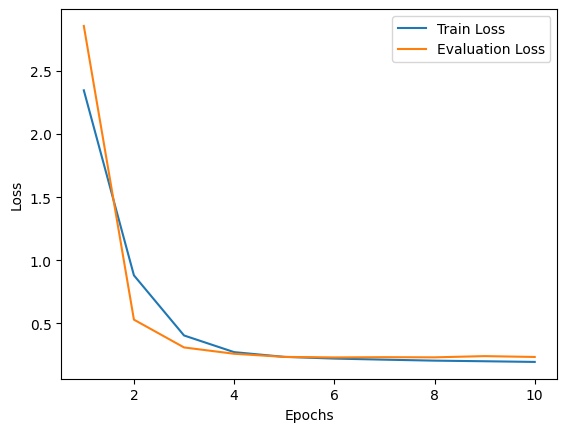

In [18]:
plot_history(history)

In [19]:
def show_predictions(model, test_loader, vocab):
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            batch_size, seq_length = inputs.size()

            # Reshape outputs to [batch_size, seq_length, vocab_size]
            outputs = outputs.view(batch_size, seq_length, -1)
            
            # Get the last time step output for each sequence in the batch
            last_time_step_outputs = outputs[:, -1, :]
        
            # Get the index of the maximum value (predicted word) for each sequence
            _, predicted_indices = torch.max(last_time_step_outputs, dim=1)
            predicted_words = [vocab.itos[idx.item()] for idx in predicted_indices]
            original_sentences = [[vocab.itos[idx.item()] for idx in sentence if idx.item() != vocab.stoi['<PAD>']] for sentence in inputs]
            
            for original_sentence, predicted_word in zip(original_sentences, predicted_words):
                print("Original Sentence:", ' '.join(original_sentence))
                print("Predicted Next Word:", predicted_word)
                print("-" * 111)
                
            # just first batch    
            break

# Example usage:
show_predictions(model, test_loader, vocab)

Original Sentence: که از جانب ستارگان دیگر می آید باید توسط خورشید خم می شود . در سال NUM ، این پیش بینی توسط آرتور <UNK> طی
Predicted Next Word: NUM
---------------------------------------------------------------------------------------------------------------
Original Sentence: در فرهنگ اسلامی به معنای عقب نشینی از نیل به <UNK> کمال و سقوط به وادی <UNK> ابدی و <UNK> ، گرفتار آمدن به <UNK>
Predicted Next Word: <UNK>
---------------------------------------------------------------------------------------------------------------
Original Sentence: سنتور ، در کامبوج فی و در آمریکا <UNK> می نامند که هر کدام دارای وجه <UNK> هستند . ساز سنتور در شماری از کشورها
Predicted Next Word: ،
---------------------------------------------------------------------------------------------------------------
Original Sentence: » ( <UNK> ) بود و انتهای آن تا بندر <UNK> که نزدیک ترین منطقه در ساحل فرانسه به انگلستان بود ، امتداد داشت .
Predicted Next Word: در
-------------------------------------------------

In [20]:
torch.save(model, "model.pth")